## Summary

At some large conferences in the computer field, hundreds of papers covering various directions can be published. Clustering by topics and contents of papers helps people find the papers more efficiently.  
Our data contains about 400 articles published at AAAI 2014, provided by UCI. It provides information including titles, authors, keywords, and abstracts.  

By vectorizing textual contents, we test clustering results with K-Means and K-Medoids. K-Means perfoms much better than K-Medoids on our dataset, with low Silouette scores and low Calinski-Harabasz scores. The best performance so far is with a Silhouette score at 0.4437, when cluster amount is set to 2 and vectorized data is dimensional reduced to 2-dimension. A pattern is that the higher the dimension is, the poorer the clustering behaves.   

The cluster results are not as ideal, as we have limited amount of data and overlapped topics that could lead to overlapped or compact clusters.  
We also experiment Fuzzy C-mean Cluster. However, as the data is not labelled, it is hard to determine which cluster algorithm gives better sensitivity and specificity.

In [42]:
import sys

import pandas as pd
import numpy as np

import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, Birch
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sksurv.metrics import concordance_index_censored
from nltk.tokenize import TweetTokenizer
from lifelines.utils import concordance_index
from scipy.spatial.distance import cdist

import missingno as msno
import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## 1. Data Pre-processing

### 1.1 Read Data In

In [2]:
# read data from source file and build data frame
data_source = './data/[UCI] AAAI-14 Accepted Papers - Papers.csv'
data_frame = pd.read_csv(data_source, sep=',')

display(data_frame)

,title,authors,groups,keywords,topics,abstract
0,Kernelized Bayesian Transfer Learning,Mehmet Gönen and Adam A. Margolin,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Transfer learning considers related but distin...
1,"""Source Free"" Transfer Learning for Text Class...","Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yu...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Transfer learning uses relevant auxiliary data...
2,A Generalization of Probabilistic Serial to Ra...,Haris Aziz and Paul Stursberg,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,The probabilistic serial (PS) rule is one of t...
3,Lifetime Lexical Variation in Social Media,"Liao Lizi, Jing Jiang, Ying Ding, Heyan Huang ...",NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,As the rapid growth of online social media att...
4,Hybrid Singular Value Thresholding for Tensor ...,"Xiaoqin Zhang, Zhengyuan Zhou, Di Wang and Yi Ma",Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...,"In this paper, we study the low-rank tensor co..."
...,...,...,...,...,...,...
393,Mapping Users Across Networks by Manifold Alig...,"Shulong Tan, Ziyu Guan, Deng Cai, Xuzhen Qin, ...",AI and the Web (AIW),Social Networks\nManifold Alignment\nHypergrap...,AIW: Machine learning and the web\nAIW: Ontolo...,Nowadays many people are members of multiple o...
394,Compact Aspect Embedding For Diversified Query...,"Xiaohua Liu, Arbi Bouchoucha, Jian-Yun Nie and...",AI and the Web (AIW),query expansion\nsearch result diversification...,AIW: Enhancing web search and information retr...,Diversified query expansion (DQE) based approa...
395,Contraction and Revision over DL-Lite TBoxes,"Zhiqiang Zhuang, Zhe Wang, Kewen Wang and Guil...",Knowledge Representation and Reasoning (KRR),Belief Change\nDescription Logic\nNon-monotoni...,KRR: Belief Change\nKRR: Description Logics\nK...,An essential task in managing DL ontologies is...
396,Zero Pronoun Resolution as Ranking,Chen Chen and Vincent Ng,NLP and Text Mining (NLPTM),Zero Pronouns\nText Mining\nNatural Language P...,NLPTM: Evaluation and Analysis,"Compared to overt pronoun resolution, there is..."


### 1.2 Drop Noise Features

Feature "groups" and "topics" cannot be completely regarded as labels, because:  
1. Some authors may choose a group or topic, but the article may more relate to another group/topic;  
2. An article may have multiple groups and topics. Thus, articles may belong to multiple categories. Such clustering will not be considered here.
3. There are many different values for groups and topics, but clustering often hopes to specify aggregation into categories to limited type amounts that are not large, such as 5/10/20;

In [3]:
data_frame.drop(columns=["groups", "topics"], inplace=True)

### 1.3 Clean up

In [4]:
# remove duplicants in data frame
data_frame.drop_duplicates(inplace=True)
# remove constant features
data_frame = data_frame.loc[:, (data_frame != data_frame.iloc[0]).any()]
# check if exists any missing data
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 397
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     398 non-null    object
 1   authors   398 non-null    object
 2   keywords  398 non-null    object
 3   abstract  398 non-null    object
dtypes: object(4)
memory usage: 15.5+ KB


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

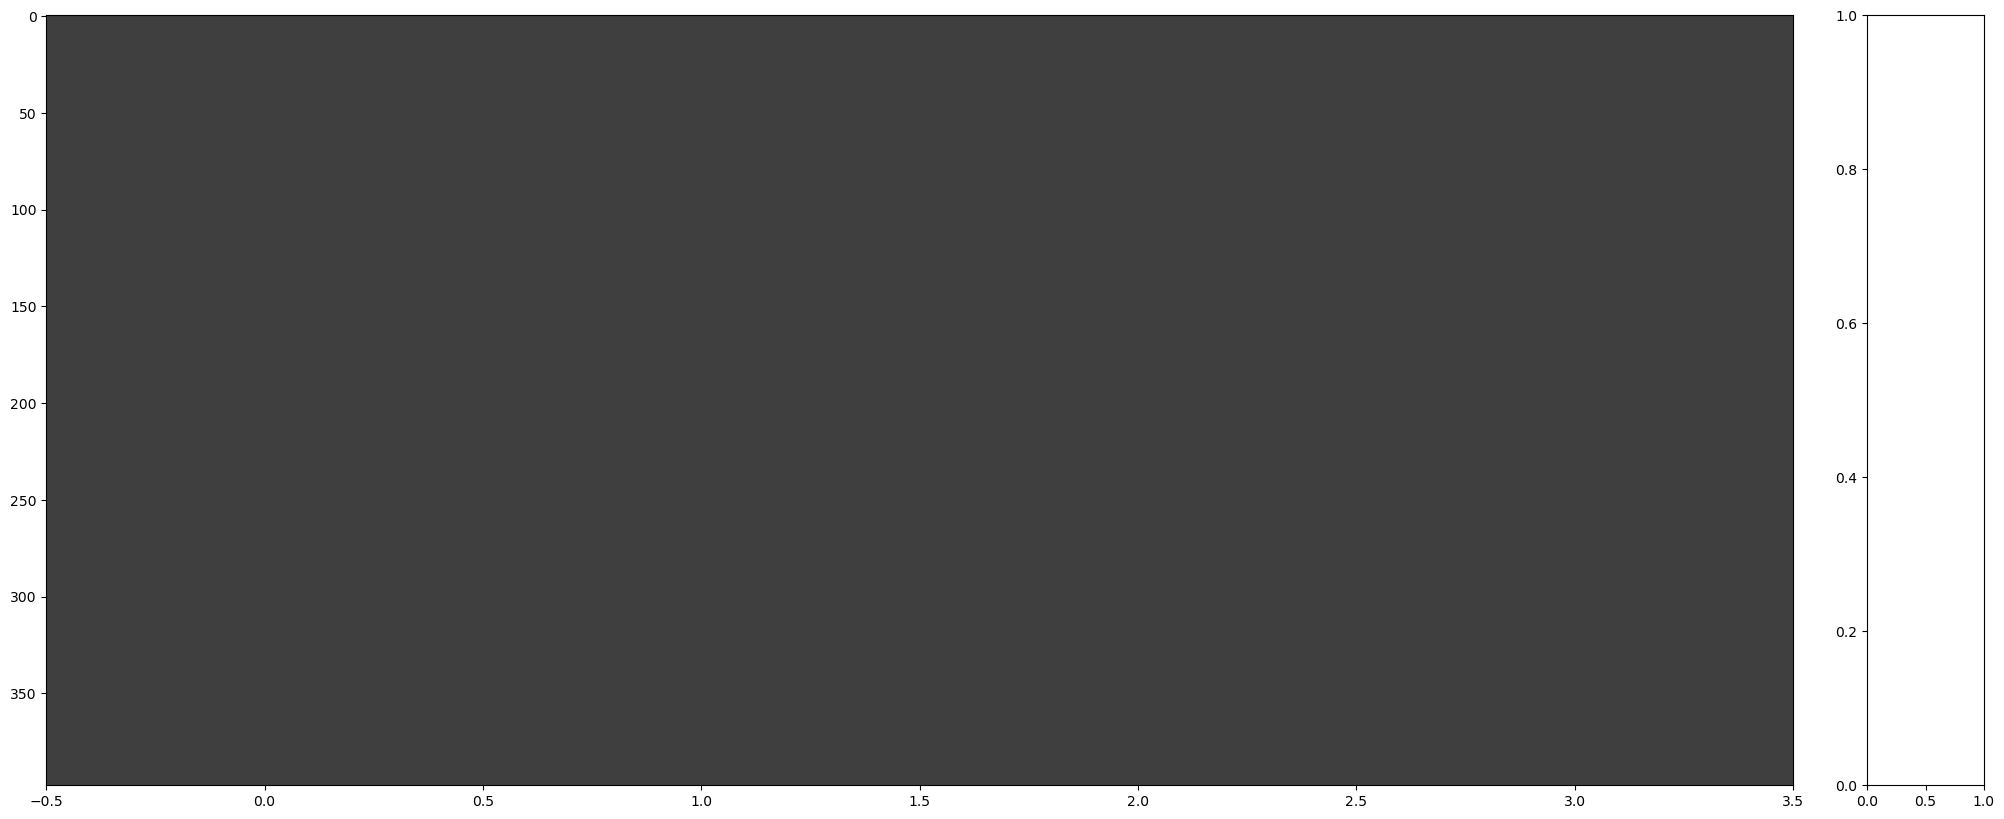

In [7]:
msno.matrix(data_frame)

The data is quite clean, no duplicates/nan-values/constant features exist.

### 1.4 Remove Unwanted Strings from Textual Contents

ref: https://datascience.stackexchange.com/questions/108685/best-way-to-vectorise-names-and-addresses-for-similarity-searching  

This section includes:
1. Modify textual contents so that words are separated by spaces and no unwanted punctuation extists;  
2. We will make every full author name separated by double spaces, and use full name for vectorization.

In [5]:
# this is to pre-modify textual context
# punctuation will be removed, and we will separate words by space
# extra terms is mainly for modify author information

def clear_punctuation(content, extra_remove=False, extra_remove_words=[], extra_sub=[]):
    # components in extra_remove_words and extra_sub have one-to-one correspondence
    content = content.lower()
    if extra_remove:
        for i in range(0, len(extra_remove_words)):
            content = content.replace(extra_remove_words[i], extra_sub[i])
    
    for punc in string.punctuation:
        content = content.replace(punc, "")
    for term in ["\n", "\t", "\s"]:
        content = content.replace(term, " ")
        
    return content

In [6]:
modified_data = {}

for col in data_frame.columns:
    all_contents = []
    
    if col == "authors":
        for content in data_frame[col]:
            all_contents.append(clear_punctuation(content, True, ["and", ","], ["", " "]))
    else:
        for content in data_frame[col]:
            all_contents.append(clear_punctuation(content))
    modified_data[col] = all_contents
        

In [7]:
data_frame = pd.DataFrame(modified_data)
data_frame

,title,authors,keywords,abstract
0,kernelized bayesian transfer learning,mehmet gönen adam a margolin,crossdomain learning domain adaptation kernel ...,transfer learning considers related but distin...
1,source free transfer learning for text classif...,zhongqi lu yin zhu sinno pan evan xiang yu...,transfer learning auxiliary data retrieval tex...,transfer learning uses relevant auxiliary data...
2,a generalization of probabilistic serial to ra...,haris aziz paul stursberg,social choice theory voting fair division soci...,the probabilistic serial ps rule is one of the...
3,lifetime lexical variation in social media,liao lizi jing jiang ying ding heyan huang ...,generative model social networks age prediction,as the rapid growth of online social media att...
4,hybrid singular value thresholding for tensor ...,xiaoqin zhang zhengyuan zhou di wang yi ma,tensor completion lowrank recovery hybrid sing...,in this paper we study the lowrank tensor comp...
...,...,...,...,...
393,mapping users across networks by manifold alig...,shulong tan ziyu guan deng cai xuzhen qin ...,social networks manifold alignment hypergraph ...,nowadays many people are members of multiple o...
394,compact aspect embedding for diversified query...,xiaohua liu arbi bouchoucha jianyun nie ale...,query expansion search result diversification ...,diversified query expansion dqe based approach...
395,contraction and revision over dllite tboxes,zhiqiang zhuang zhe wang kewen wang guilin qi,belief change description logic nonmonotonic r...,an essential task in managing dl ontologies is...
396,zero pronoun resolution as ranking,chen chen vincent ng,zero pronouns text mining natural language pro...,compared to overt pronoun resolution there is ...


### 1.5 Vectorize

ref: https://maxilect.com/blog/vectorization-of-similar-goods-names/

In [64]:
# ref: https://stackoverflow.com/questions/42689278/python-sklearn-it-idf-how-to-split-by-default-space
# ref: https://medium.com/@d.goglia/embed-your-favourite-tokenizer-in-tfidfvectorizer-b9f3441491c1

# tokenizer for processing author names
def names_tokenizer(text):
    tok = TweetTokenizer()
    return tok.tokenize(text)

In [10]:
vectorizer = TfidfVectorizer(tokenizer=names_tokenizer, min_df=0.01, max_df=1.0, ngram_range=(2,4))
model = vectorizer.fit(data_frame["authors"])
values = model.transform(data_frame["authors"]).toarray()
names = model.get_feature_names_out()
names

C:\Users\ext.yiwen\anaconda3\envs\mltrain\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


array(['alan fern', 'ariel procaccia', 'chris ding', 'craig boutilier',
       'jie tang', 'juanzi li', 'prasad tadepalli', 'tieyan liu',
       'tuomas sholm', 'vincent conitzer', 'zhihua zhou'], dtype=object)

To vectorize author names, ngram range is set to (2,4), since extarcting single words for names is not that meaningfull and we will try use full name as much as we can.  
The risk may be, as can see from the word cloud:  
1. there are only limited features to be extracted if we consider full name
2. Extracted terms have similar frequencies.  
The impact of the author names can weaken by this vectorization.

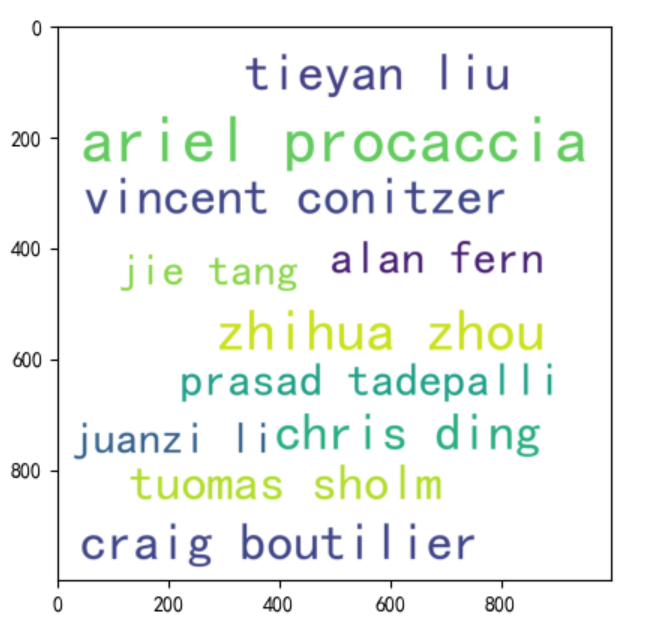

In [11]:
all_features = [[] for i in range(data_frame.shape[0])]

#vectorizer = TfidfVectorizer(min_df=0.01, max_df=1.0)

for col in data_frame:
    all_contents = []
    
    if col == "authors":
        vectorizer = TfidfVectorizer(tokenizer=names_tokenizer, min_df=0.01, max_df=1.0, ngram_range=(2,4))
        model = vectorizer.fit(data_frame["authors"])
        values = model.transform(data_frame["authors"]).toarray()
        all_features = np.concatenate((all_features, values), axis=1)
        
    else: 
        vectorizer = TfidfVectorizer(min_df=0.01, max_df=1.0, ngram_range=(1,5))
        model = vectorizer.fit(data_frame[col])
        values = model.transform(data_frame[col]).toarray()
        all_features = np.concatenate((all_features, values), axis=1)

all_features.shape

(398, 4259)

## 2. Clustering

ref: https://www.geeksforgeeks.org/clustering-performance-evaluation-in-scikit-learn/   
ref: https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/    
ref: https://stats.stackexchange.com/questions/52838/what-is-an-acceptable-value-of-the-calinski-harabasz-ch-criterion  
ref: https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c#:~:text=The%20Calinski%2DHarabasz%20index%20also,score%20%2C%20the%20better%20the%20performances.

For evaluating cluster quality, we will use: Silhouette Score, Calinski-Harabasz.
A good clustering has high Adjusted Rand Index, high Silhouette Score, high Calinski-Harabasz.

We will test K-mean clustering and K-mediods clustering. 

In [11]:
# to calculate clustering evaluation scores
def get_scores(train_X, results):
    silhouette = silhouette_score(train_X, results)
    ch = calinski_harabasz_score(train_X, results)
    
    return silhouette, ch

### 2.1 Clustering with TF-IDF

In [ ]:
clusters = ["K-Mean", "K-Medoids"]
k_values = [2,3,4,5,6,8,10,15,20, 30, 50, 70, 100]

for cluster in clusters:
    print("Current using: {}".format(cluster))
    silhouette_scores, ch_scores = [], []
    for k in k_values:
        print("K is {}".format(k))
        if cluster=="K-Mean":
            model = KMeans(n_clusters=k)
        if cluster=="K-Medoids":
            model = KMedoids(n_clusters=k)
        
        results = model.fit_predict(all_features)
        silhouette, ch = get_scores(all_features, results)
        
        silhouette_scores.append(silhouette)
        ch_scores.append(ch)
        
    print("Silhouette Score: {}".format(str(silhouette_scores)))
    print("Calinski-Harabasz Score: {}".format(str(ch_scores)))

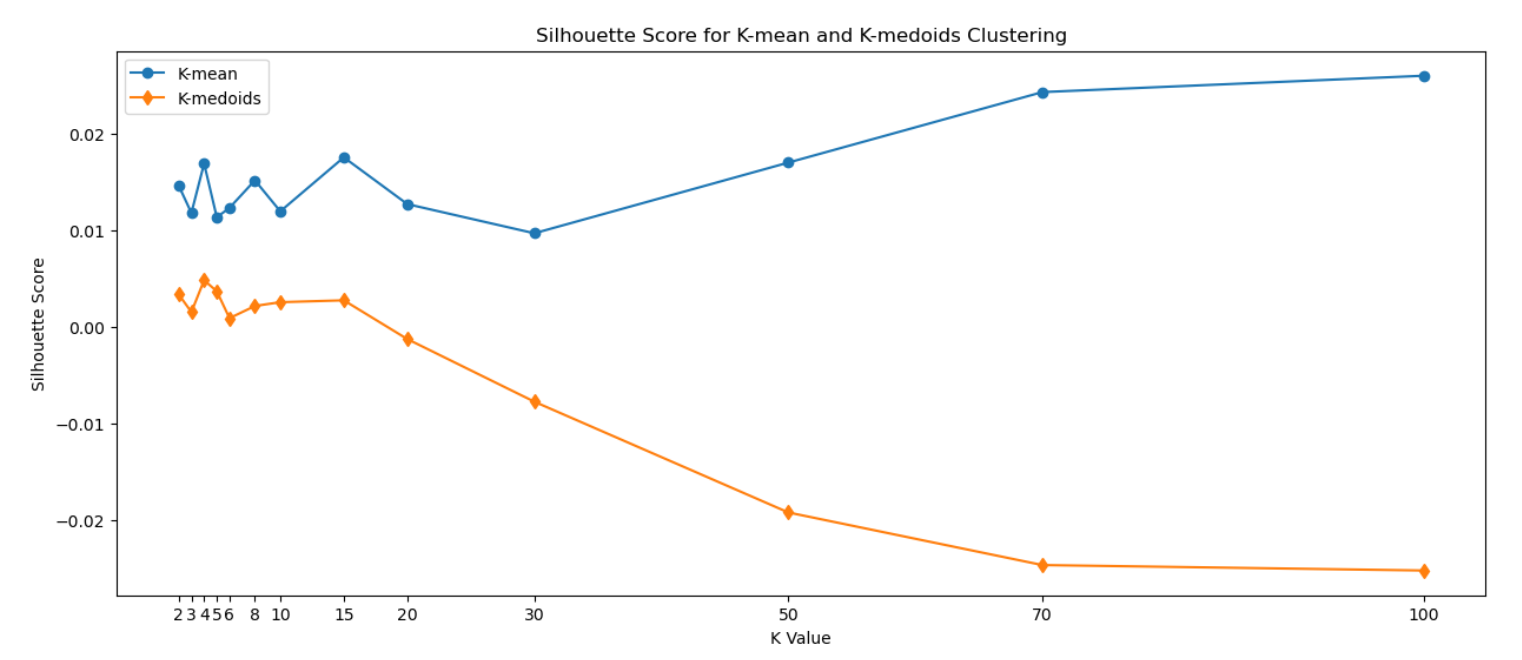  
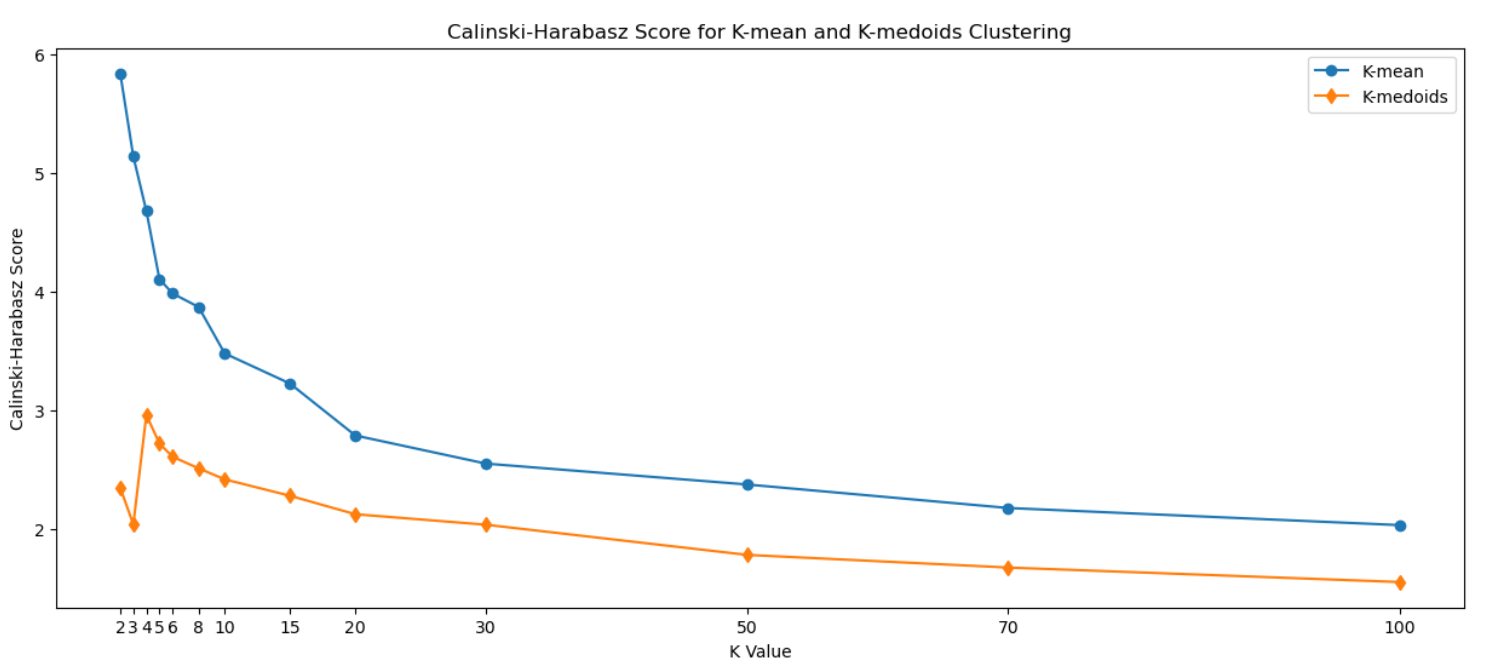

ref: https://stackoverflow.com/questions/44611359/how-do-i-interpret-silhouette-coefficient-from-k-means-clustering?rq=4  
ref: https://datascience.stackexchange.com/questions/71688/when-to-use-k-medoids-over-k-means-and-vice-versa  

The silhouette of a point measures how similar a point is to its cluster versus the next closest cluster. This is a ratio of the distances to the cluster centers, normalized so that "1" is a perfect match to its cluster and "-1" a perfect mismatch.  
The silhouette scores in our experiment suggests that the clustering results are not ideal. For K-mean clustering, the silhouette score climbs up as the K grows. An assumption is that we have only limited sample amounts and the actual categories for the samples are far more than the k values we tested.  
Silhouette scores for K-medoids are lower than K-mean.  
From algorithm-perspective, the main difference is that medoids belong to the data points. You will never have a medoid that is somewhere between points. Instead, it will be superimposed on an existing point. Which basically suggests that clustering should have poor performaces when exist samples that have overlapped categories. 

Calinski-Harabasz scores' trend follows a general elbow curve.  Same, as the Silhouette scores, K-mean works betetr with the given dataset.  

Since both two algorithms above do not carry out good clustering results, we will iterate back to data pre-processing.

### 2.2 Identify Noise Data

As discussed in section 1.5, when we use full names as a vectorization term, only 11 features are extracted with similar frequencies. This might disturb the cluster results since many of the samples will have all zero vectors for "author" feature.

In [54]:
# drop author feature and vectorize

data_frame = data_frame.drop(columns=["authors"])

all_features = [[] for i in range(data_frame.shape[0])]

#vectorizer = TfidfVectorizer(min_df=0.01, max_df=1.0)

for col in data_frame:
    all_contents = []
    
    vectorizer = TfidfVectorizer(min_df=0.01, max_df=1.0, ngram_range=(1,5))
    model = vectorizer.fit(data_frame[col])
    values = model.transform(data_frame[col]).toarray()
    all_features = np.concatenate((all_features, values), axis=1)

all_features.shape

(398, 4248)

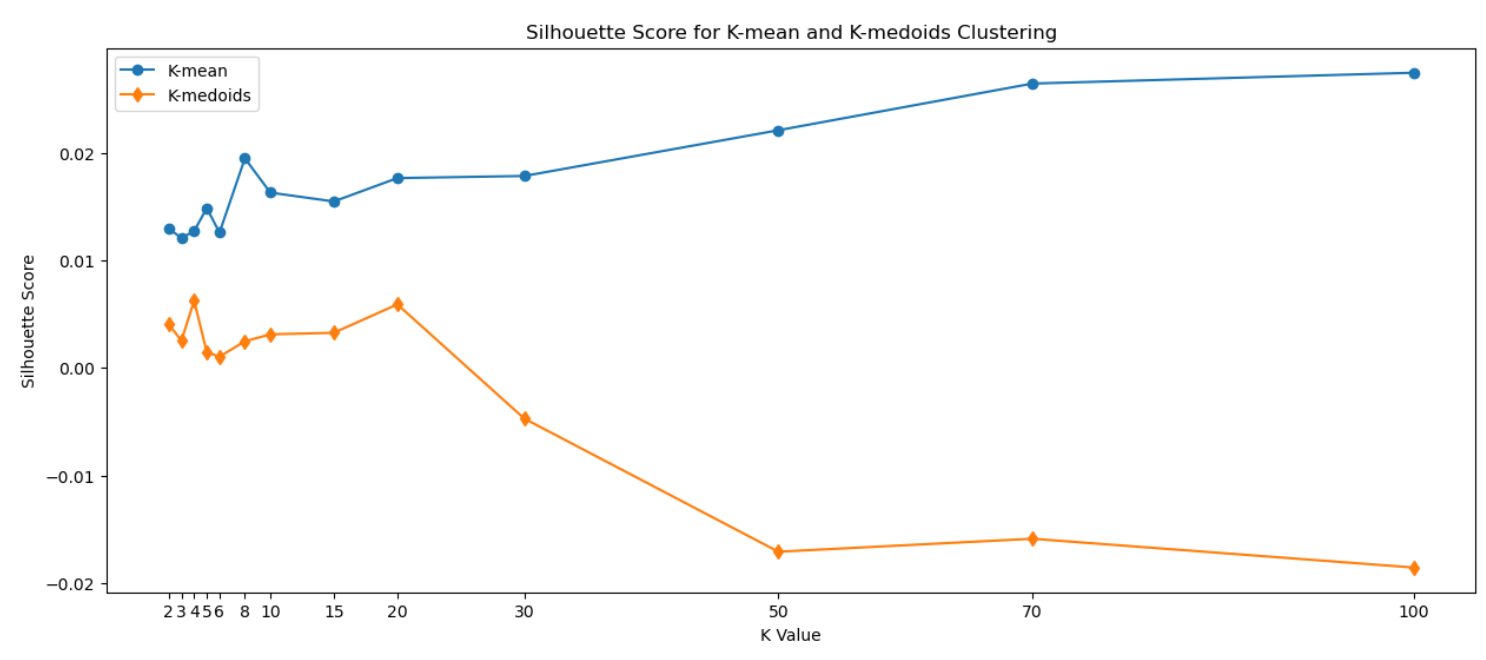
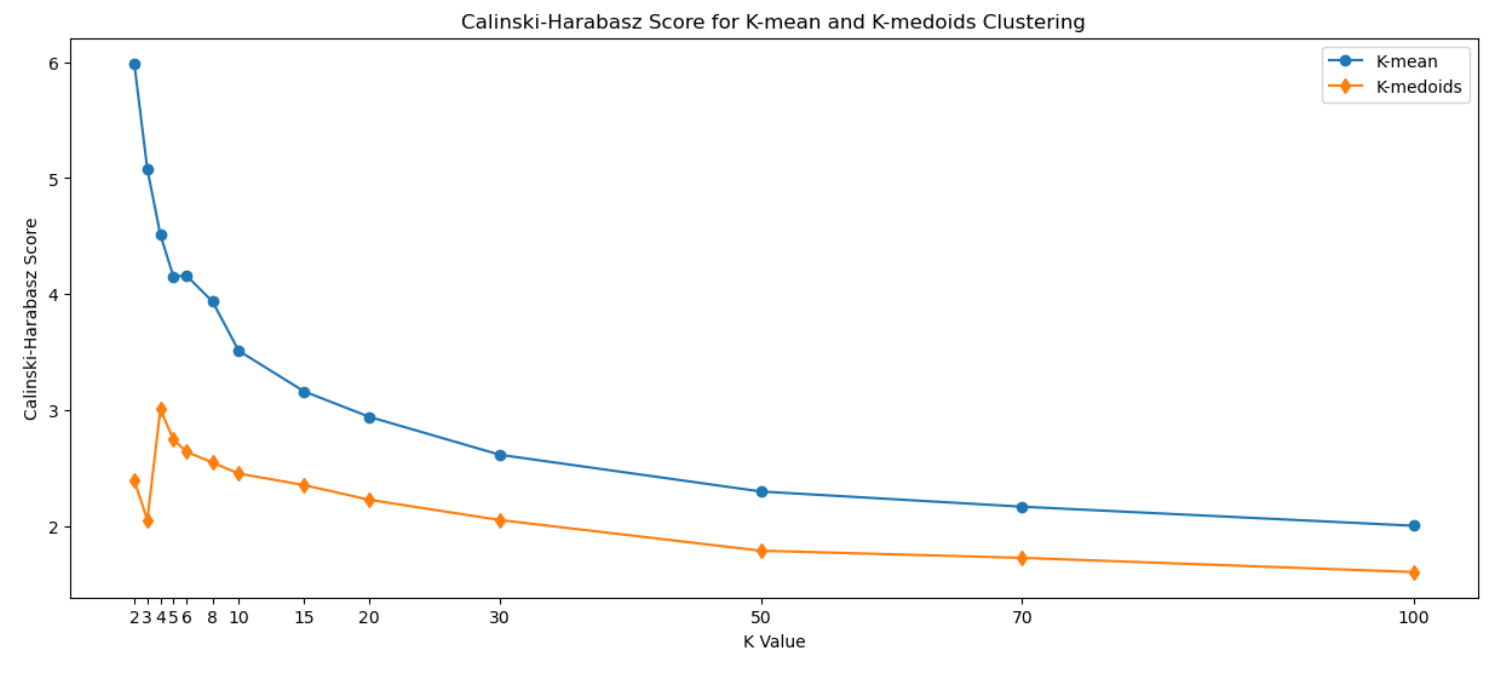

Clustering scores have no obvious improvements with the author feature being dropped.  

K-medoids still have most of the Silhouette scores below zero, suggesting a large portion of samples are misclassified. The K-mean cluster starts to behave more stable, but still with Silhouette scores close to zero.  

We will try to use another vectorization method for further investigation. In this section, we could come to a conclusion that with TF-IDF, neither clustering method is sensitive to the outliers introduced by feature "authors".


### 2.3 Clustering with Count Vectorization

In [55]:
data_frame.describe()

,title,keywords,abstract
count,398,398,398
unique,398,398,398
top,kernelized bayesian transfer learning,crossdomain learning domain adaptation kernel ...,transfer learning considers related but distin...
freq,1,1,1


In [8]:
# drop author feature and vectorize

data_frame = data_frame.drop(columns=["authors"])

all_features = [[] for i in range(data_frame.shape[0])]

#vectorizer = TfidfVectorizer(min_df=0.01, max_df=1.0)

for col in data_frame:
    all_contents = []
    
    vectorizer = CountVectorizer(min_df=0.01, max_df=1.0, ngram_range=(1,5))
    model = vectorizer.fit(data_frame[col])
    values = model.transform(data_frame[col]).toarray()
    all_features = np.concatenate((all_features, values), axis=1)

all_features.shape

(398, 4248)

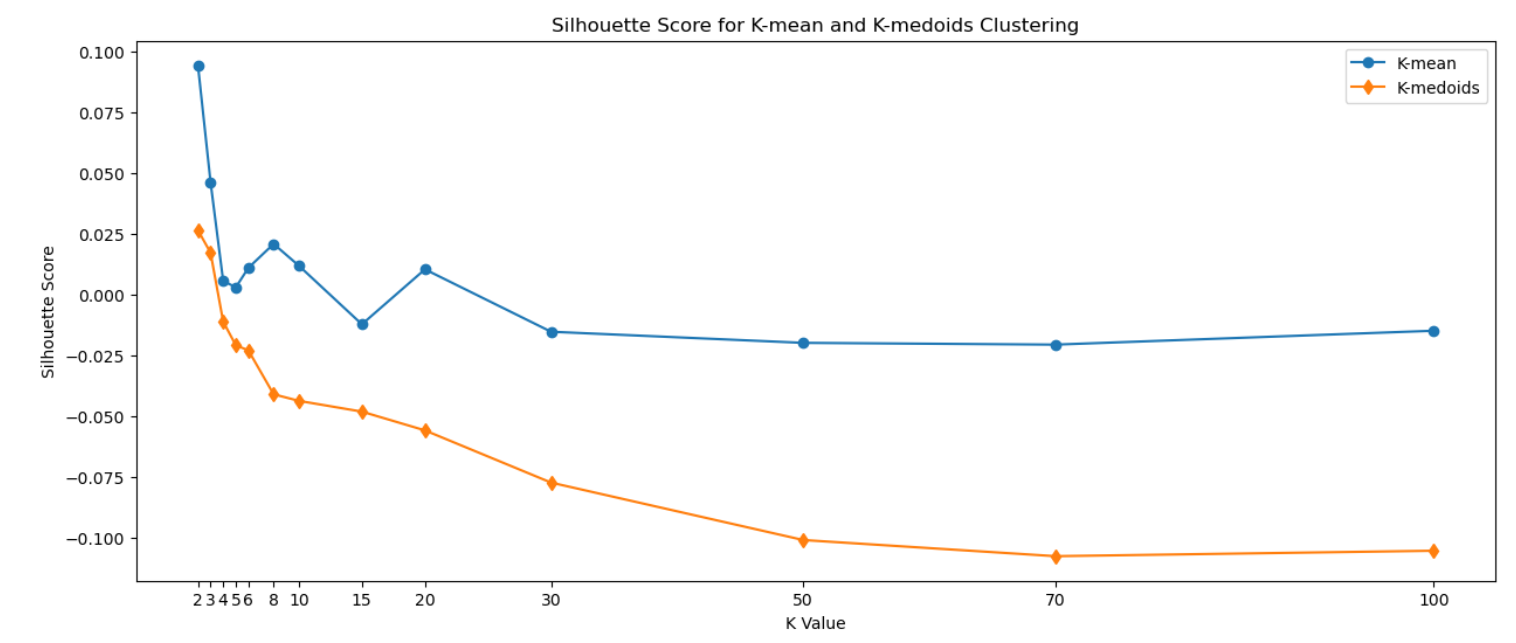
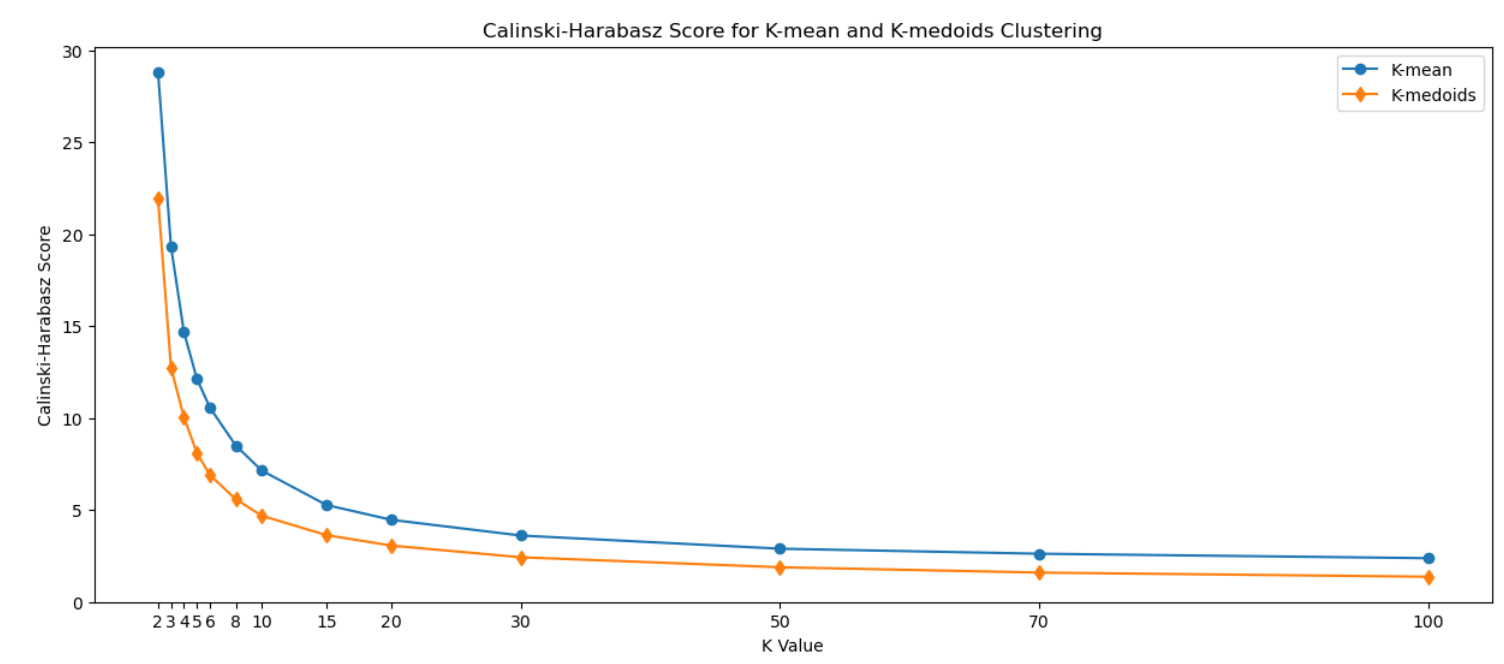

ref: https://en.wikipedia.org/wiki/Clustering_high-dimensional_data#:~:text=Four%20problems%20need%20to%20be,becomes%20intractable%20with%20increasing%20dimensionality.  

There is significant improvement on both Silhouette scores and Calinski-Harabasz scores. Calinski-Harabasz scores' curves are much more smoother. Thus, we could say that Count vectorizer is a more suitable pre-processing method for our data set.  

However, Silhouette scores are still close to zero, and it indicates overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

By observing the data set afer vectorization, it came to our notice that most of the number is zero. Also, each sample point has more than 4000 dimensions. This could be the main reason why the cluster behaviors couldn't be improved.  

There are mainly four problems need to be overcome for clustering in high-dimensional data:  
1. Due to the exponential growth of the number of possible values with each dimension, complete enumeration of all subspaces becomes intractable with increasing dimensionality;
2. The concept of distance becomes less precise as the number of dimensions grows, since the distance between any two points in a given dataset converges;
3. A cluster is intended to group objects that are related, based on observations of their attribute's values. However, given a large number of attributes some of the attributes will usually not be meaningful for a given cluster;
4. Given a large number of attributes, it is likely that some attributes are correlated. Hence, clusters might exist in arbitrarily oriented affine subspaces.

In short, it is imperative for dimensionality reduction.

## 3. Dimensionality Reduction

ref: https://machinelearningmastery.com/dimensionality-reduction-for-machine-learning/  

The fundamental reason for the curse of dimensionality is that high-dimensional functions have the potential to be much more complicated than low-dimensional ones, and that those complications are harder to discern.

In [ ]:
data_frame = data_frame.drop(columns=["authors"])
all_features = [[] for i in range(data_frame.shape[0])]

#vectorizer = TfidfVectorizer(min_df=0.01, max_df=1.0)

for col in data_frame:
    all_contents = []
    
    vectorizer = CountVectorizer(min_df=0.01, max_df=1.0)
    model = vectorizer.fit(data_frame[col])
    values = model.transform(data_frame[col]).toarray()
    all_features = np.concatenate((all_features, values), axis=1)

all_features.shape

In [87]:
amount_dimensions = [2, 3, 5, 7, 10, 15, 20, 30, 50, 100, 150]

In [ ]:
# PCA dimensionality reduction
clusters = ["K-Mean", "K-Medoids"]
k_values = [2,3,4,5,6,8,10,15,20,30,50]

for amount in amount_dimensions:
    pca_features = PCA(n_components=amount).fit_transform(all_features)
    for cluster in clusters:
        print("Current dimesion: {}; using: {}".format(amount, cluster))
        silhouette_scores, ch_scores = [], []
        for k in k_values:
            print("K is {}".format(k))
            if cluster=="K-Mean":
                model = KMeans(n_clusters=k)
            if cluster=="K-Medoids":
                model = KMedoids(n_clusters=k)

            results = model.fit_predict(pca_features)
            silhouette, ch = get_scores(pca_features, results)

            silhouette_scores.append(silhouette)
            ch_scores.append(ch)

        print("Silhouette Score: {}".format(str(silhouette_scores)))
        print("Calinski-Harabasz Score: {}".format(str(ch_scores))) 

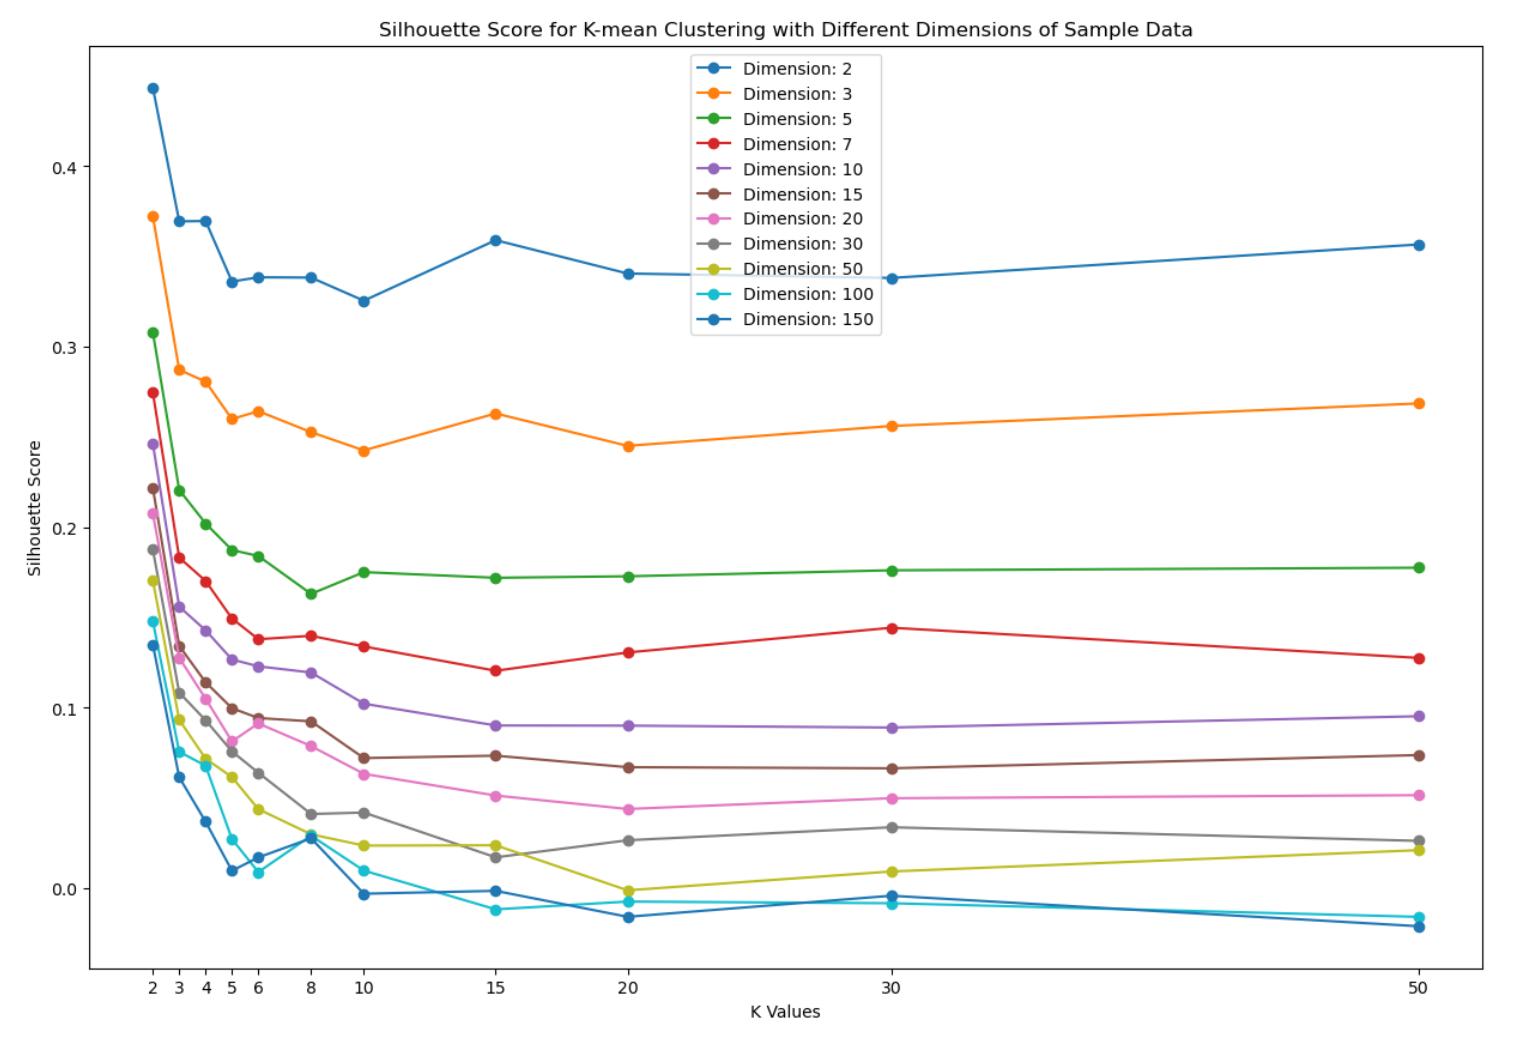
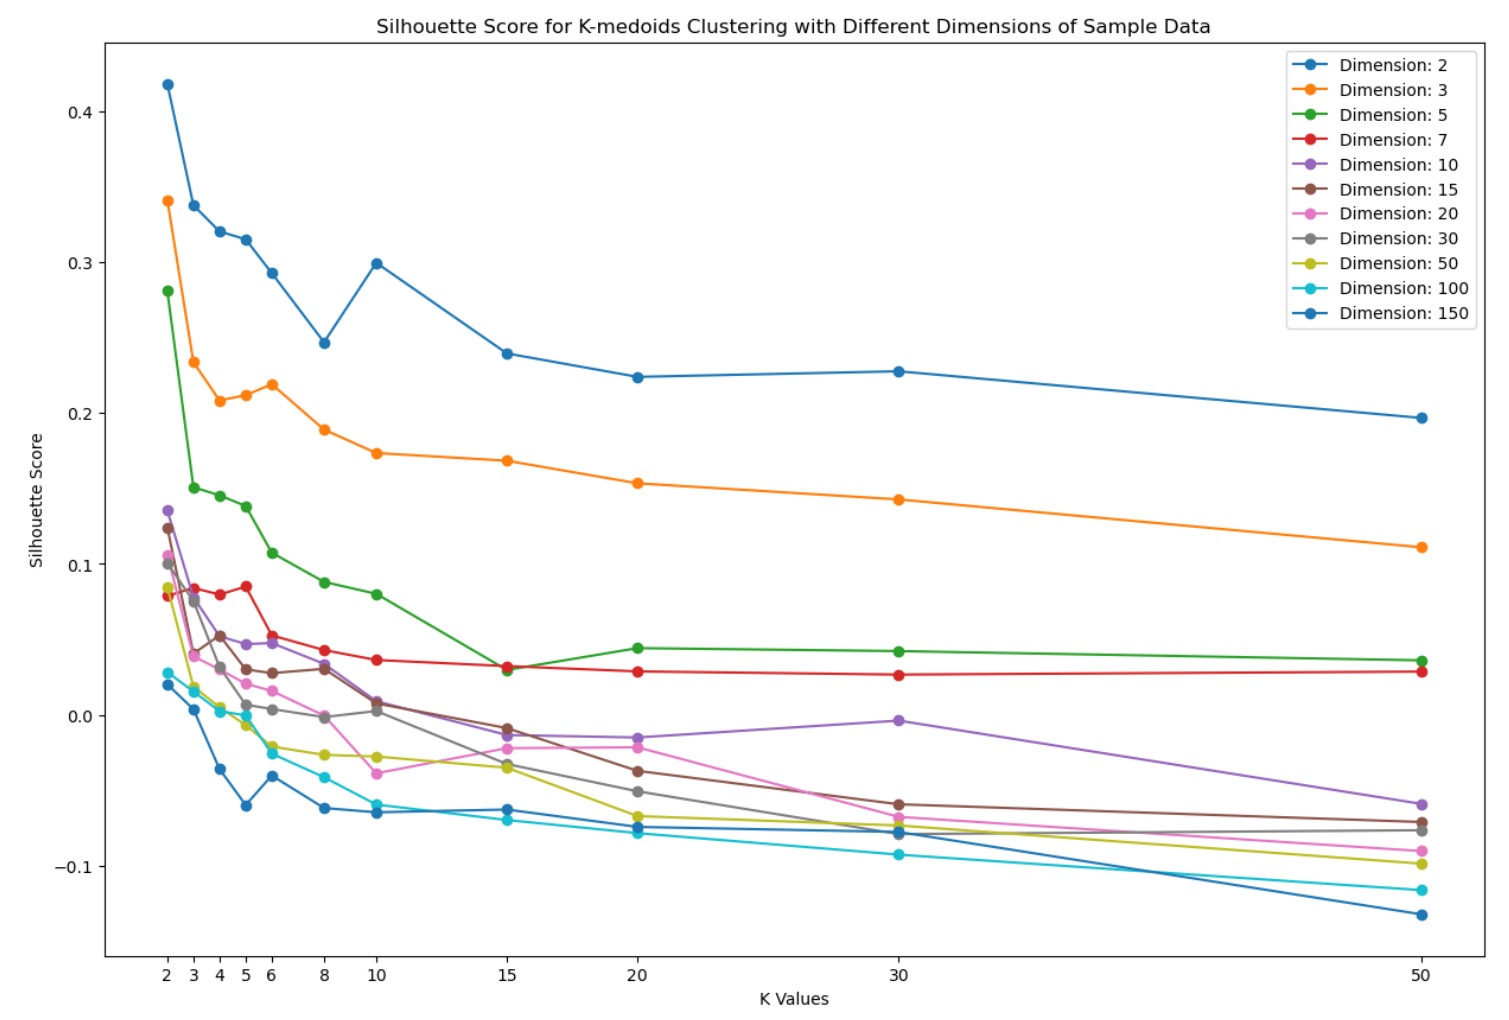
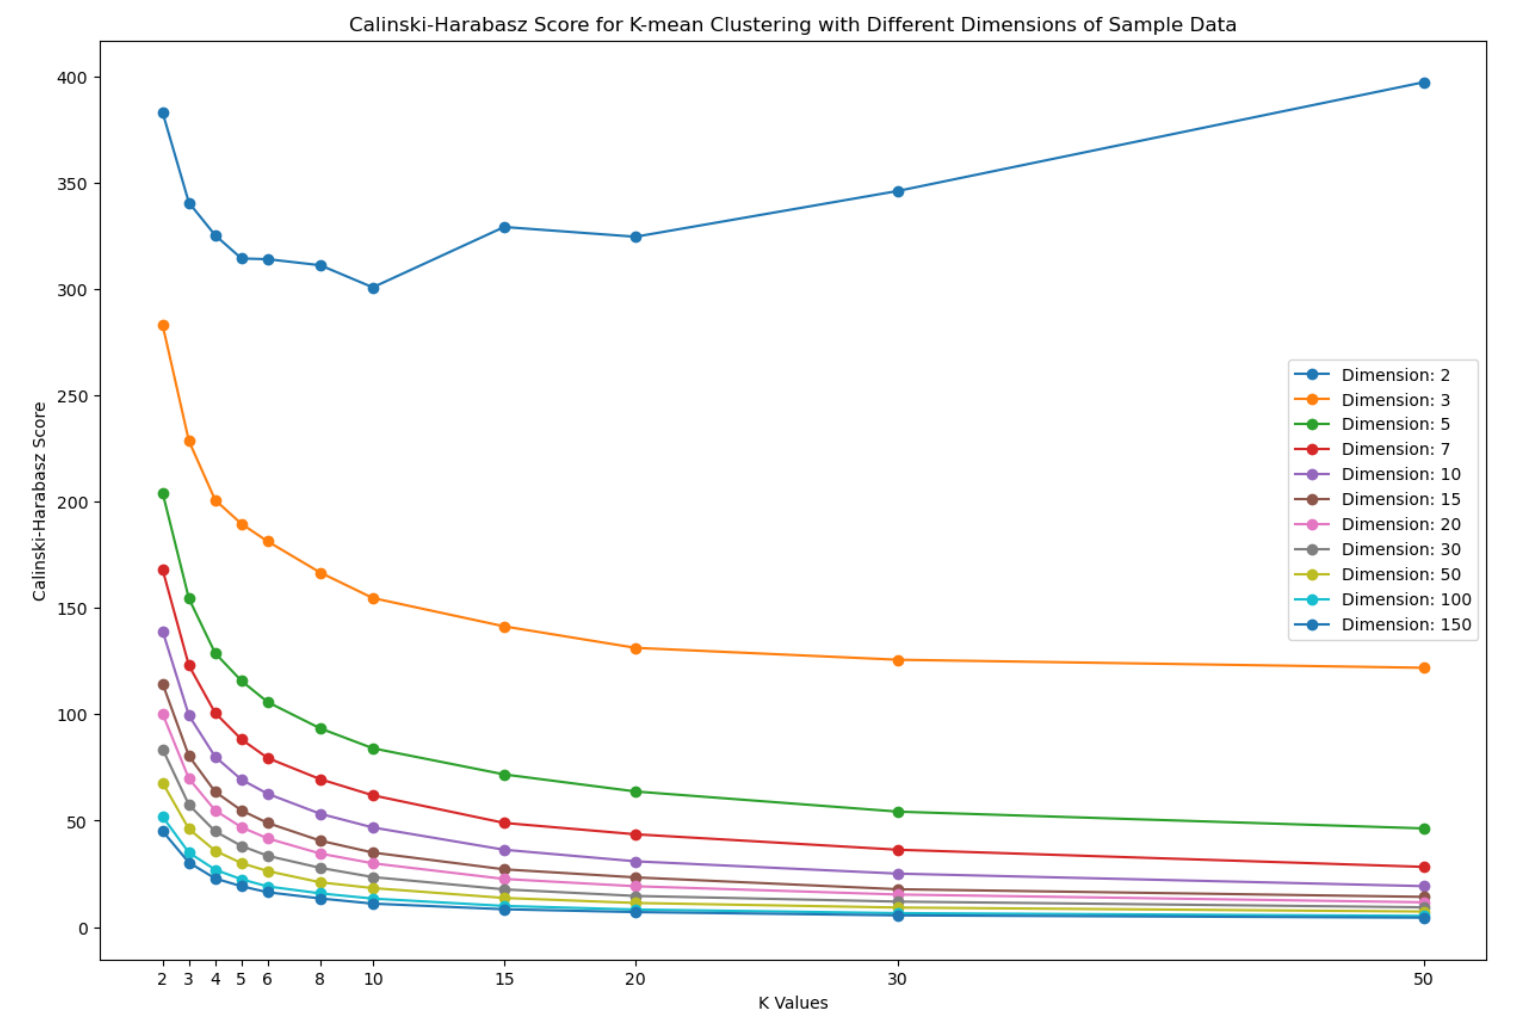
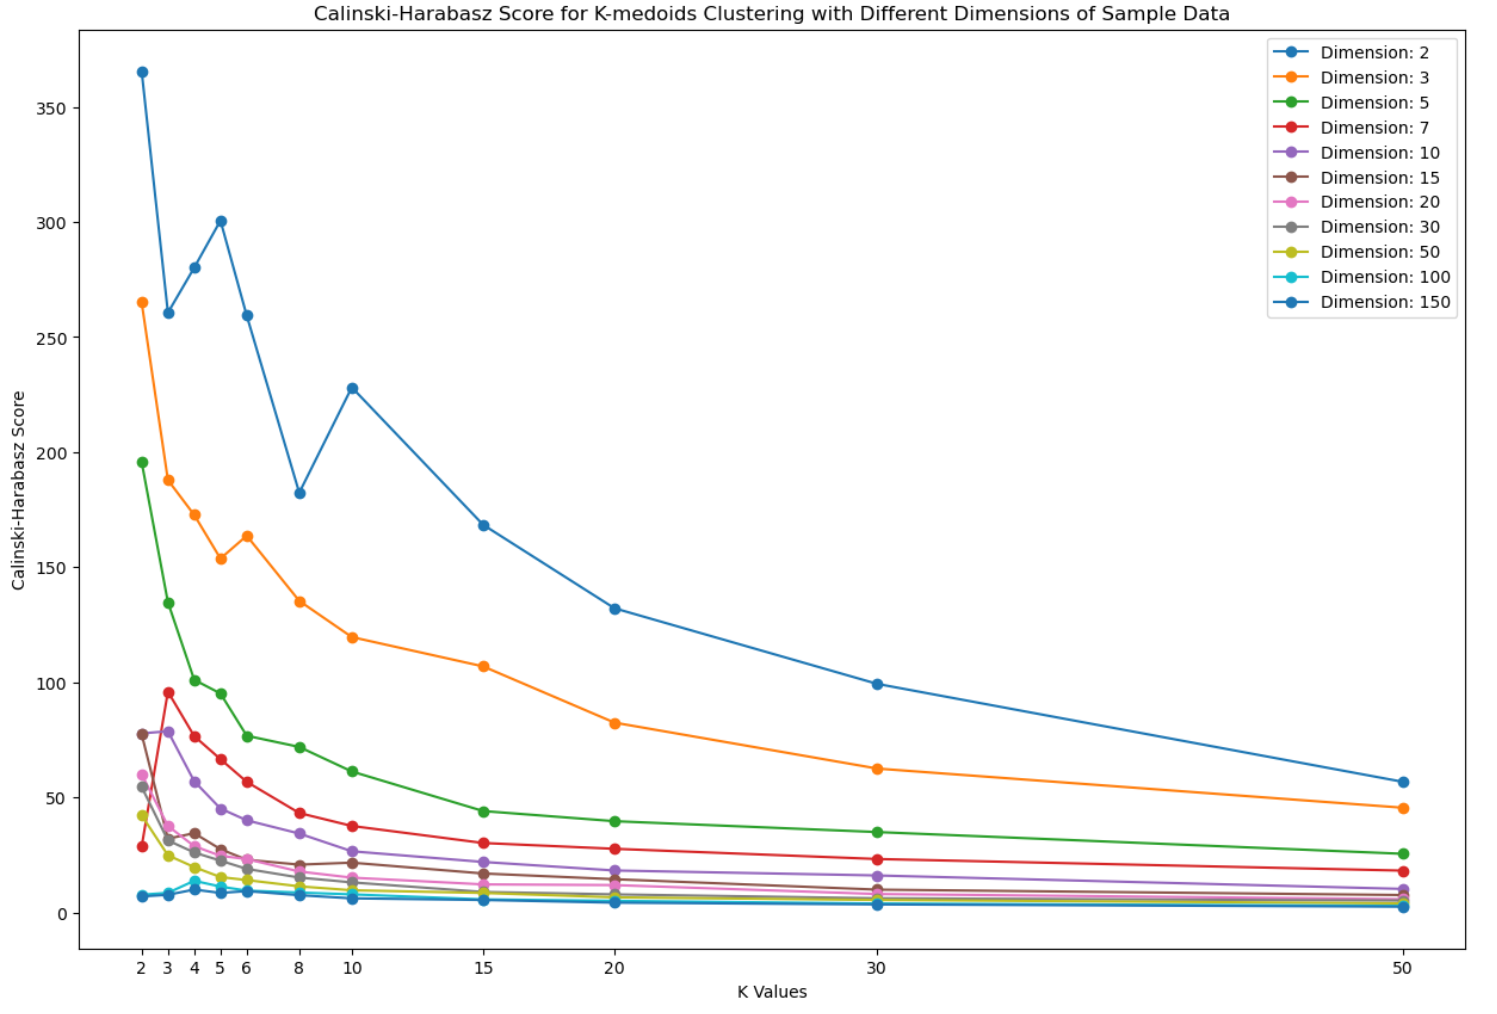

After dimensionality reduction, most of the scores for clustering follow the shape of an elbow model curve. As discussed in Section 4.3, higher dimension on sample data suggests lower scuttering scores and poorer behaviors. Thus, with the dimension reduced, both two evaluation scores sufficiently increase.  

The highest Silhouette score for K-mean is at 0.4437, and the highest for K-medoids is at 0.4182, both with train data dimension at 2 and k equals to 2. As for Calinski-Harabasz, K-mean ghas much higher scores, that is, much better behavior.  

For K-mean, the second best behaviors are:
1. dimension:2, k:15
2. dimension:3, k:2  
For K-medoids, they are:
1. dimension:3, k:2
It is an interesting fact that when K-mean with 2-dimension data and 50 clusters, the Silhouette score is low whilst the Calinski-Harabasz score reaches the highest. Given the fact that we only have no more than 400 samples, this is perhaps due to overfitting.  

Based on the analysis, we will use the best performances above for generating scatter plots.



## 4. Visualize Clustering Results

### 4.1 PCA to Dimension 2

In [ ]:
# when dimension is reduced to 2 and k set to 2
pca_features = PCA(n_components=2).fit_transform(all_features)
kmeans = KMeans(n_clusters= 2)
kmedoids = KMedoids(n_clusters= 2)

kmean_labels = kmeans.fit_predict(pca_features)
kmedoid_labels = kmedoids.fit_predict(pca_features)

In [ ]:
# the other 2d scatter plot would use the same method
label0 = pca_features[kmean_labels==0]
label1 = pca_features[kmean_labels==1]
label2 = pca_features[kmean_labels==2]

#Plotting the results
plt.scatter(label0[:,0] , label0[:,1])
plt.scatter(label1[:,0] , label1[:,1])
plt.scatter(label2[:,0] , label2[:,1])

plt.title("K-Means -- feature dimension:2, cluster:2")

plt.show()

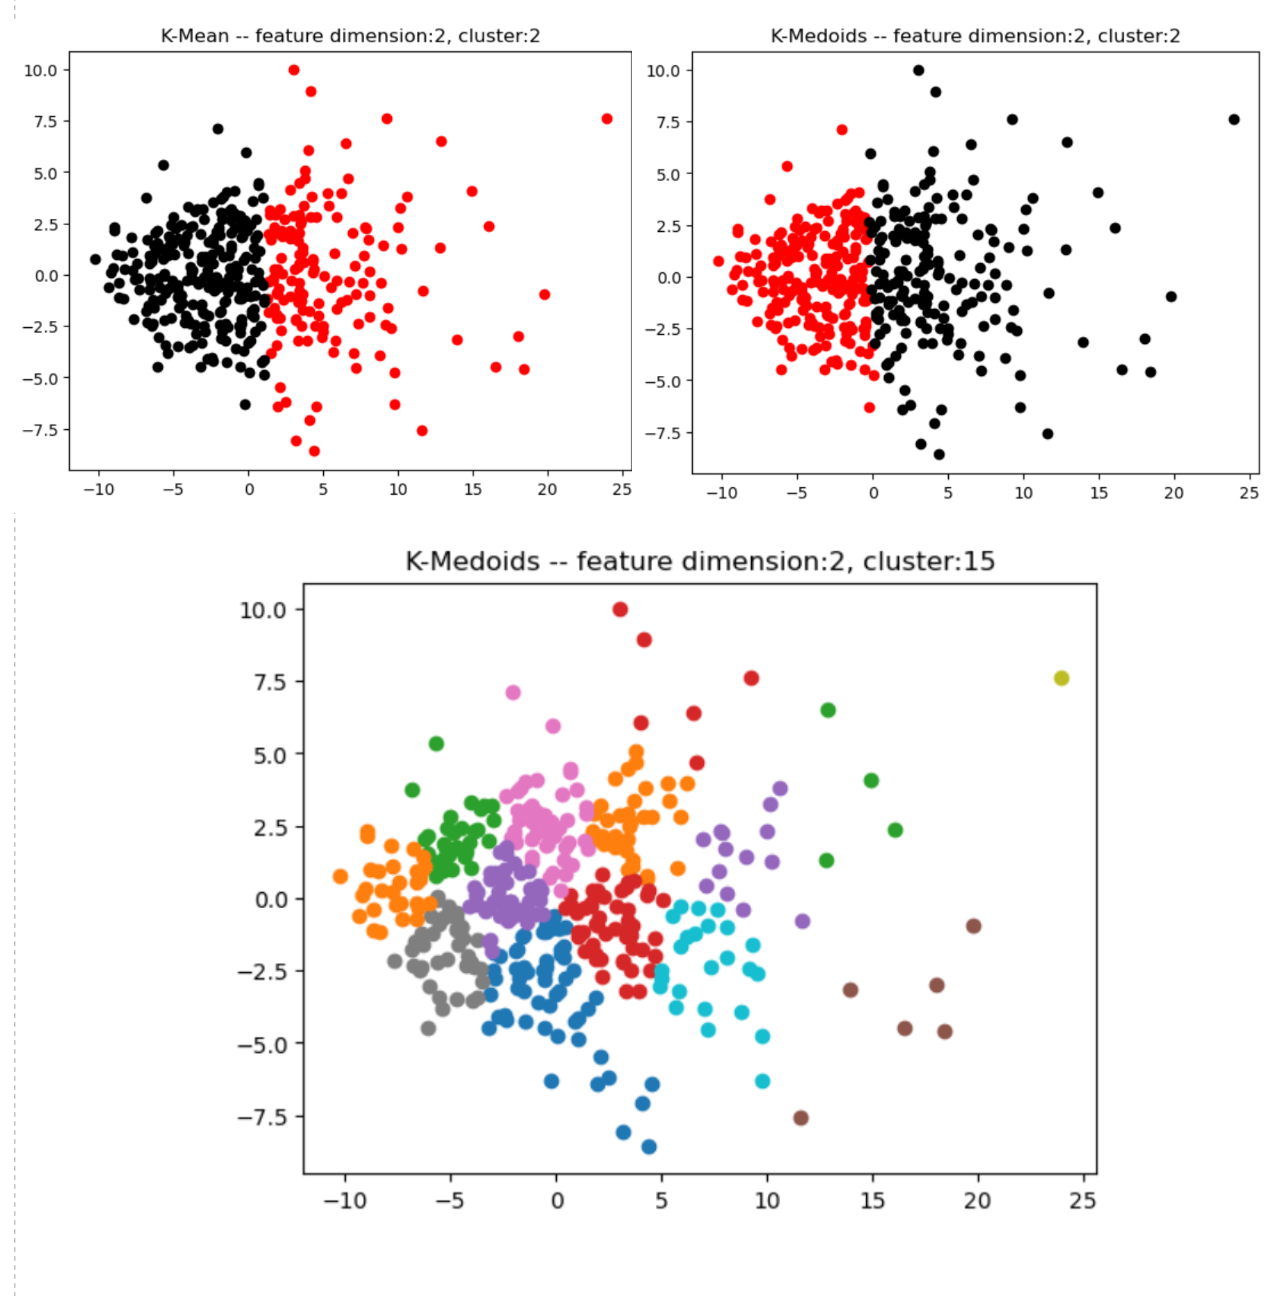

### 4.2 PCA to Dimension 3

In [127]:
# when dimension is reduced to 2 and k set to 2
pca_features = PCA(n_components=3).fit_transform(all_features)
kmeans = KMeans(n_clusters= 2)
kmedoids = KMedoids(n_clusters= 2)

kmean_labels = kmeans.fit_predict(pca_features)
kmedoid_labels = kmedoids.fit_predict(pca_features)

In [ ]:
# the other 3d scatter plot would use the same method
label0 = pca_features[kmedoid_labels==0]
label1 = pca_features[kmedoid_labels==1]

#Plotting the results
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ="3d")

ax.scatter3D(label1[:,0], label1[:,1], label1[:,2])
ax.scatter3D(label0[:,0] , label0[:,1], label0[:,2])

plt.title("K-Medoids -- feature dimension:2, cluster:2")

plt.show()

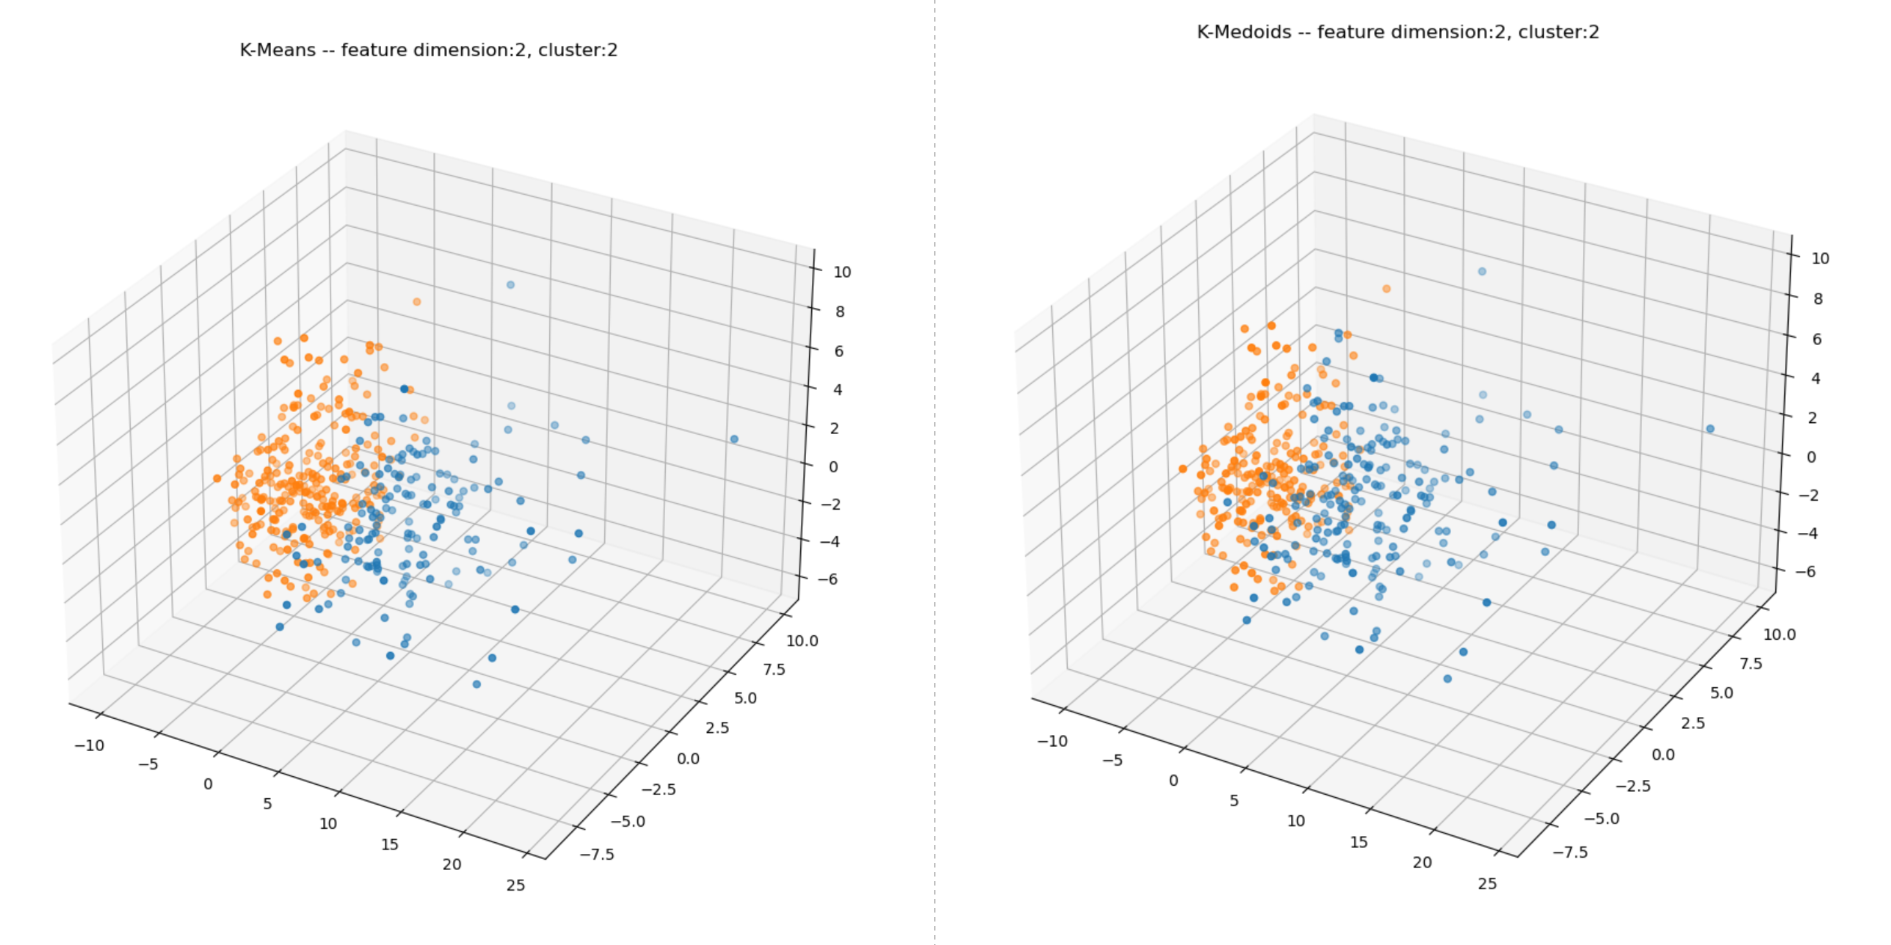
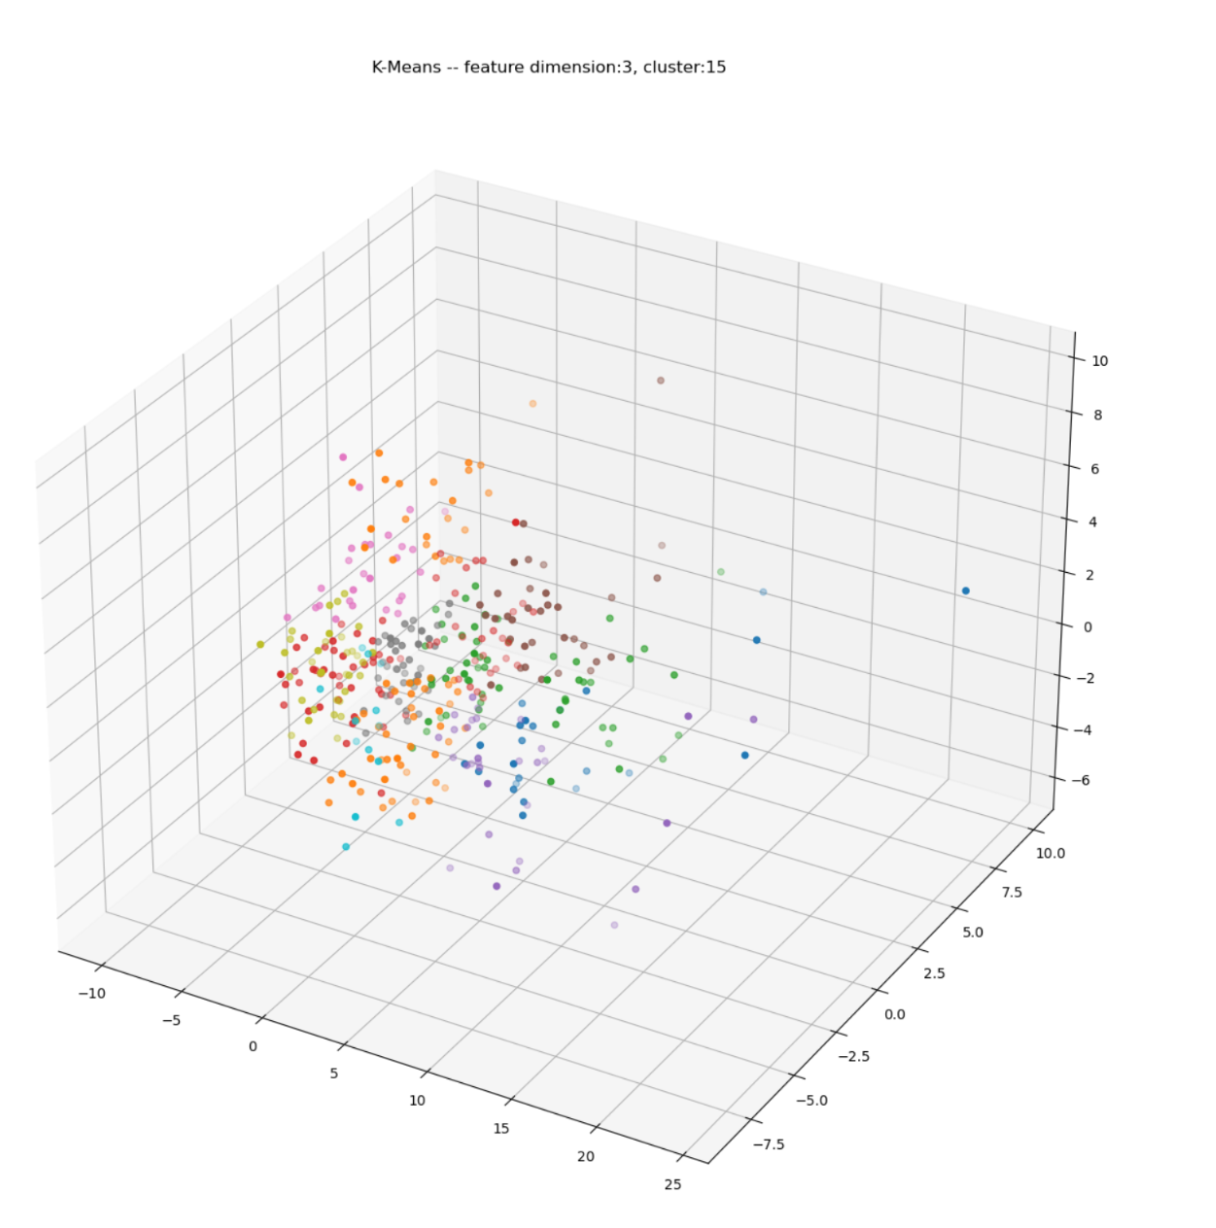

### Observations:  
1. When cluster amount is set to 2, one cluster is comparatively more compact, whilst the others have more outlier points.
2. When cluster amount is set to 15, sample data with two dimensions has better clustering results than with three dimensions. Clusters on three-dimension data are overlapped. Clusters on two-dimension data appears to have lesser overlaps but still, not ideal.
3. From the visualization, we could get better understanding on why cluster scores are not as good. The inter-cluster distances between clusters are too short. And edge samples get too close to each other, that is, clusters are not separate from each other. Also, there are still enough outliers which results in small intra-cluster similarity.


## Fuzzy C-Means Clustering

ref: https://medium.com/@avinashkella/understanding-fuzzy-c-means-clustering-with-python-implementation-a-beginners-guide-3dbdf180393b  

In [57]:
pca_features = PCA(n_components=2).fit_transform(all_features)
pca_features.shape

(398, 2)

In [ ]:
# Apply fuzzy c-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    pca_features.T, 3, 2, error=1, maxiter=1000, init=None
)
# Assign each data point to the cluster with the highest membership value
label = np.argmax(u, axis=0)

# the other 2d scatter plot would use the same method
label0 = pca_features[label==0]
label1 = pca_features[label==1]
label2 = pca_features[label==2]

#Plotting the results
plt.scatter(label0[:,0] , label0[:,1])
plt.scatter(label1[:,0] , label1[:,1])
plt.scatter(label2[:,0] , label2[:,1])

plt.title("Fuzzy C-Means -- feature dimension:2, cluster:2")

plt.show()


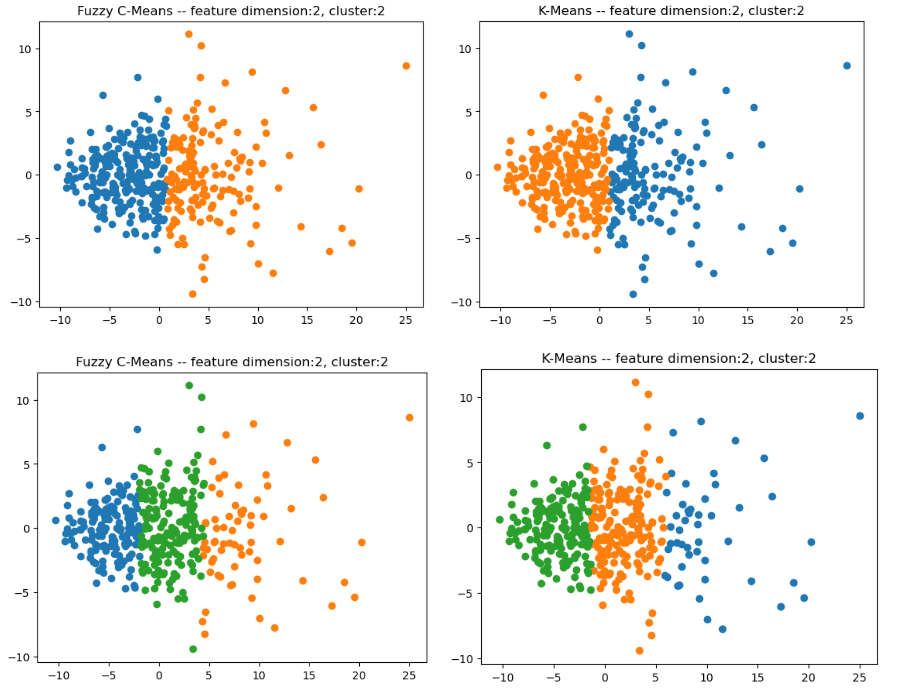

We also tried Fuzzy C-means for clustering. Compared to K-Means, the edges between clusters get more blurred, but in general, the visualized diagrams look similar. However, as Fuzzy C-Means is a soft clustering, Silhouette scores and Calinski-Harabasz are lower than K-means.   

Due to our data not being labeled(not knowing the ground truth), it is a bit difficult to analyze which one is better based on clustering accuracy.
